In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
Pkg.add("Tables")
Pkg.add("DataFrames")
Pkg.add("RobotZoo")
Pkg.add("FiniteDiff")
Pkg.add("Convex")
Pkg.add("ECOS")
Pkg.add("Plots")
Pkg.add("JLD2")
Pkg.add("Test")
Pkg.add("MeshCat")
import MathOptInterface as MOI
import Ipopt 
import FiniteDiff
import ForwardDiff as FD
import Convex as cvx 
import ECOS
using LinearAlgebra
using Plots
using Random
using JLD2
using Test
using MeshCat
const mc = MeshCat
using TrajOptPlots
using StaticArrays
using Printf
using Tables
using DataFrames
using CSV
using RobotZoo

  Activating environment at `~/workspace/coursework_ws/s2023/16745/project/Project.toml`
    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/workspace/coursework_ws/s2023/16745/project/Project.toml`
  No Changes to `~/workspace/coursework_ws/s2023/16745/project/Manifest.toml`
   Resolving package versions...
  No Changes to `~/workspace/coursework_ws/s2023/16745/project/Project.toml`
  No Changes to `~/workspace/coursework_ws/s2023/16745/project/Manifest.toml`
   Resolving package versions...
  No Changes to `~/workspace/coursework_ws/s2023/16745/project/Project.toml`
  No Changes to `~/workspace/coursework_ws/s2023/16745/project/Manifest.toml`
   Resolving package versions...
  No Changes to `~/workspace/coursework_ws/s2023/16745/project/Project.toml`
  No Changes to `~/workspace/coursework_ws/s2023/16745/project/Manifest.toml`
   Resolving package versions...
  No Changes to `~/workspace/coursework_ws/s2023/16745/project/Project.

In [2]:
include(joinpath(@__DIR__, "utils","fmincon.jl"))
include(joinpath(@__DIR__, "utils","vo_visualizer.jl"))

vis_traj! (generic function with 1 method)

In [3]:
IJulia.set_max_stdio(1 << 20); # https://julialang.github.io/IJulia.jl/stable/manual/usage/ --> Need more visualization

# Project Code: Hybrid Trajectory Optimization for Autonomous Vehicles with Velocity-Loss Collision Constraints
This file is modified from Zac Manchester's 16-745 class in order to demonstrate the application discussed in: "Trajectory Optimization for Vegetation Override in Off-road Driving". The actual vehicle code cannot be released due to project limitations.

In this problem, I am using a direct method to optimize a driving trajectory for a simple bicycle model using a hybrid dynamics/multi-phase formulation. The "hybrid" part of this problem comes in from specifying an "event" in the hybrid dynamics that corresponds to a collision. We will solve this problem using IPOPT.


## The Dynamics
I will model the dynamics of the car as with a simple nonlinear bicycle model, with the following state and control:

$$\begin{align} x = \begin{bmatrix} p_x \\ p_y \\ \theta \\ \delta \\ v \end{bmatrix}, &\quad \quad u = \begin{bmatrix} a \\ \dot{\delta} \end{bmatrix}  \end{align} $$ 

where $p_x$ and $p_y$ describe the 2d position of the bike, $\theta$ is the orientation, $\delta$ is the steering angle, and $v$ is the velocity. The controls for the bike are acceleration $a$, and steering angle rate $\dot{\delta}$.  

In [37]:
function car_dynamics(x::Vector, u::Vector)::Vector
    # Nonlinear Bicycle Model's Continuous Time Dynamics 
    px, py, θ, δ, v = x 
    a, δdot, h = u 
    lf = 1.412 # VEHICLE PARAMS
    L  = 2.972 # VEHICLE PARAMS
    β = atan(lf * δ, L)
    s,c = sincos(θ + β)
    ω = v*cos(β)*tan(δ) / L
    
    vx = v*c 
    vy = v*s 
    
    xdot = [
        vx,
        vy,
        ω,
        δdot, 
        a
    ]
    
    return xdot 
end

function collision_velocity_loss(r)
    # Compute Mason (2012) Model
    k = 0.527
    α = 30000
    γ = 1440/1000 * 9.81
    D = 0.03175
    LT = 0.3048
    m = 901
    h = 0.533
    v = sqrt((2 * k * α * γ * D * LT)/(m *(h + LT/2)) )
    return v
end

function collision_jump_map(x,r)
    # The Vehicle experiences a collision
    xn = x
    xn[5] = x[5] - collision_velocity_loss(r)
    return xn
end

collision_jump_map (generic function with 1 method)

In [31]:
# DIFFERENT INTEGRATION STRATEGIES


function rk4(ode::Function, x::Vector, u::Vector)::Vector
    # USING RK4 WITH "FREE TIME" FORMULATION, HERE THE FREE TIME PARAMETER CORRESPONDS TO u[3].
    k1 = u[3] * ode(x,        u)
    k2 = u[3] * ode(x + k1/2, u)
    k3 = u[3] * ode(x + k2/2, u)
    k4 = u[3] * ode(x + k3,   u)
    return x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end

rk4 (generic function with 1 method)

Time to setup and solve a constrained nonlinear program.  The optimization problem looks complicated but each piece should make sense and be relatively straightforward to implement. First we have the following LQR cost function that will track $x_{ref}$ (`Xref`) and $u_{ref}$ (`Uref`):

$$  J(x_{1:N},u_{1:N-1}) = \sum_{i=1}^{N-1} \bigg[ \frac{1}{2} (x_i - x_{ref,i})^TQ(x_i - x_{ref,i}) + \frac{1}{2} (u_i-u_{ref,i})^TR(u_i-u_{ref,i}) \bigg] + \frac{1}{2}(x_N - x_{ref,N})^TQ_f(x_N - x_{ref,N})$$

Which goes into the following full optimization problem:
   $$ \begin{align} \min_{x_{1:N},u_{1:N-1}} \quad & J(x_{1:N},u_{1:N-1}) & \\ 
 \text{st} \quad &  x_1 = x_{ic} & \tag{1}\\
 \quad & x_N = x_{g} &\tag{2}\\
 &  x_{k+1} = f(x_k,u_k)  &\text{for } k \not\in  \text{collision} \\
  &  x_{k+1} = g(f(x_k,u_k))  &\text{for } k \in   \text{collision} \\
  & x_l \geq -x \\
  & x_u \geq x\\
  & u_l \geq -u\\
  & u_u \geq u  
 \end{align}$$
 
 Each constraint is now described, with the type of constraint for `fmincon` in parantheses:
 1. Initial condition constraint **(equality constraint)**. 
 2. Terminal condition constraint **(equality constraint)**. 
 3. Driving discrete dynamics **(equality constraint)**. .
 4. Control and State **(primal bounds)**.

And here we have the list of mathematical functions to the Julia function names:
- $f$ is `car_dynamics` + `RK4`
- $g$ is `collision_jump_map`

In [99]:
function reference_trajectory(col_index, nx, xic, xg, dt, N, xcol, ref_vel)
    # creates a reference Xref and Uref for walker 
    
    #u     a ̇δ h
    Uref = [[0.01; 0.01; 0.1] for i = 1:(N-1)]
    
    #x     px py  y  d  v
    Xref = [zeros(nx) for i = 1:N]
    
    b4_col = col_index
    after_col = N - 1 - col_index
    xs1 = range(xic[1], xcol[1], length = b4_col)
    xs2 = range(xcol[1], xg[1], length = after_col)
    ys = range(xic[2], xg[2], length = N)
    ts = range(xic[3], xg[3], length = N)
    vs1 = range(xic[5], xcol[5], length = b4_col)
    vs2 = range(xcol[5], xg[5], length = after_col)
    Xref[1] = 1*xic 
    Xref[N] = 1*xg 
    
    for i = 2:(N-1) 
        if (i<col_index)
            Xref[i] = [xs1[i],ys[i], ts[i], 0, vs1[i]]
        elseif (i==col_index)
            Xref[i] = [xcol[1]; xcol[2]; xcol[3]; 0; xcol[5]]
        else
            Xref[i] = [xs2[i-col_index],ys[i-col_index], ts[i-col_index], 0, vs2[i-col_index]]
        end
    end
        
    return Xref, Uref
end

reference_trajectory (generic function with 4 methods)

In [100]:
function create_idx(nx,nu,N)    
    # our Z vector is [x0, u0, x1, u1, …, xN]
    nz = (N-1) * nu + N * nx # length of Z 
    x = [(i - 1) * (nx + nu) .+ (1 : nx) for i = 1:N]
    u = [(i - 1) * (nx + nu) .+ ((nx + 1):(nx + nu)) for i = 1:(N - 1)]
    
    # constraint indexing for the (N-1) dynamics constraints when stacked up
    c = [(i - 1) * (nx) .+ (1 : nx) for i = 1:(N - 1)]
    nc = (N - 1) * nx # (N-1)*nx 
    
    return (nx=nx,nu=nu,N=N,nz=nz,nc=nc,x= x,u = u,c = c)
end

function car_cost(params::NamedTuple, Z::Vector)::Real
    # cost function 
    idx, N, xg = params.idx, params.N, params.xg
    Q, R, Qf = params.Q, params.R, params.Qf
    Xref,Uref = params.Xref, params.Uref
    
    # CAN DONE: input vehicle tracking LQR cost 
    J = 0 
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]]
       
        J += (0.5*transpose(xi-Xref[i]) * Q * (xi-Xref[i]) + 0.5*transpose(ui-Uref[i]) * R * (ui-Uref[i]))

    end
    
    # taken from earlier: dont forget terminal cost - Thanks! 
    xN = Z[idx.x[N]]
    J += 0.5*transpose(xN-Xref[N]) * Qf * (xN-Xref[N])
    
    return J 
end

function car_dynamics_constraints(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt
        
    # create c in a ForwardDiff friendly way (check HW0)
    c = zeros(eltype(Z), idx.nc)
    
    collision_occured = false
    
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]] 
        xip1 = Z[idx.x[i+1]]

        if (i == params.col_index)
                c[idx.c[i]] = collision_jump_map(rk4(car_dynamics, xi, ui), params.model.tree_rad) - xip1
        else
                c[idx.c[i]] = rk4(car_dynamics, xi, ui) - xip1
        end
    end
    return c 
end

    
function car_equality_constraint(params::NamedTuple, Z::Vector)::Vector
    N, idx, xic, xg = params.N, params.idx, params.xic, params.xg 

    # CAN DONE: return all of the equality constraints 
    ind_x0 = first(params.idx.x) # INITIAL CONDITION
    ind_xf = last(params.idx.x)  # FINAL GOAL
    return [Z[ind_x0] - params.xic; Z[ind_xf] - params.xg; Z[idx.x[params.col_index][1:4]] - params.xcol[1:4]; car_dynamics_constraints(params, Z)]
end

function car_inequality_constraint(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt
        
    c = zeros(eltype(Z), 1)
    c[1] = Z[idx.x[params.col_index][5]]
    return c
end

car_inequality_constraint (generic function with 1 method)

In [101]:
    # dynamics parameters 
    model = (g = 9.81, mb= 5.0, mf = 1.0, ℓ_min = 0.5, ℓ_max = 1.5, tree_rad = 0.03175)
    
    # problem size 
    nx = 5 
    nu = 3 
    tf = 10 
    dt = 0.1 # 0.05 is also reasonable... 
    t_vec = 0:dt:tf 
    N = 101
    
    # constants 
    rad2deg = 180/pi
    deg2rad = pi/180

    col_index = 50
    ref_vel   = 0.5
    # constraints
    min_v = 0      # Right now, no going backwards
    max_v = 10 # Max Limiter on the Car --> 10 m/s
    max_steer = 35 *deg2rad # Vehicle can't steer any more than this
    min_steer = -1 * max_steer # Vehicle can't steer any more than this
    max_accel = 0.8  # Max Acceleration
    min_accel = -1 * max_accel
    max_strrate = 5 * deg2rad # Highest rate of turn for the wheel
    min_strrate = -1 * max_strrate # Highest rate of turn for the wheel
    time_lower = 0.01 # Lowest Allowable Time
    time_upper = 2*dt # Highest Allowable Time

    # initial and goal states 
    #x     px py  y  d  v
    xic1 = [0; 0; 0; 0; 0]
    xg1 =  [40; 0; 0; 0; 0.0]
    xcol1 = [20; 0; 0; 0; collision_velocity_loss(model.tree_rad)]

    xr1 = [0; 0; 0; 0; ref_vel]
    xr2 =  [40; 0; 0; 0; ref_vel]
    
    # LQR cost function (tracking Xref, Uref)
    Q = diagm([1.0; 1.0; 1.0; 0.0; 1.0]);
    R = diagm([1.0; 10.0; 100.0]) # Note the time regularizer 
    Qf = 1*Q;
    
    # create indexing utilities 
    idx = create_idx(nx,nu,N)

    # reference trajectory 
    Xref, Uref = reference_trajectory(col_index, nx, xr1, xr2, dt, N, xcol1, ref_vel)

    # put everything useful in params 
    params = (
        model = model,
        col_index = col_index,
        nx = nx,
        nu = nu,
        tf = tf, 
        dt = dt, 
        t_vec = t_vec,
        N = N, 
        xic = xic1, 
        xg = xg1,
        xcol = xcol1,
        idx = idx,
        Q = Q, R = R, Qf = Qf,
        Xref = Xref, 
        Uref = Uref
    )



    # Primal bounds (constraint 11)
    x_l = -Inf*ones(idx.nz) # update this 
    x_u =  Inf*ones(idx.nz) # update this
        
    for i=1:N
        x_l[(nx+nu)*(i-1)+4] = min_steer
        x_u[(nx+nu)*(i-1)+4] = max_steer    
        x_l[(nx+nu)*(i-1)+5] = min_v
        x_u[(nx+nu)*(i-1)+5] = max_v
        if (i < N)
            x_l[(nx+nu)*(i-1)+6] = min_accel
            x_u[(nx+nu)*(i-1)+6] = max_accel
            x_l[(nx+nu)*(i-1)+7] = min_strrate
            x_u[(nx+nu)*(i-1)+7] = max_strrate
            x_l[(nx+nu)*(i-1)+8] = time_lower
            x_u[(nx+nu)*(i-1)+8] = time_upper              
        end
    end
    
    # The bounds for our one ineqaulity constraint
    c_l = xcol1[5]*ones(1)
    c_u = max_v*ones(1)

    
    # CAN DONE: initialize z0 with the reference Xref, Uref 
    z0 = zeros(idx.nz) # update this
    m = 1
    for x_indx in idx.x
       z0[x_indx] =  Xref[m]
       m += 1
    end
    p = 1
    for u_indx in idx.u
       z0[u_indx] =  Uref[p]
       p += 1
    end     
        
    # adding a little noise to the initial guess is a good idea 
    z0 = z0 + (1e-6)*randn(idx.nz)
    
    diff_type = :auto 
    
    Z = fmincon(car_cost,car_equality_constraint,car_inequality_constraint,
                x_l,x_u,c_l,c_u,z0,params, diff_type;
                tol = 1e-6, c_tol = 1e-6, max_iters = 10_000, verbose = true)
    
    # pull the X and U solutions out of Z 
    X = [Z[idx.x[i]] for i = 1:N]
    U = [Z[idx.u[i]] for i = 1:(N-1)]
    
    # ------------plotting--------------
    Xm = hcat(X...);
    Um = hcat(U...);
    Xrefm = hcat(Xref...);
    Urefm = hcat(Uref...);

---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :auto (ForwardDiff.jl)----
---------testing objective gradient-----------------
---------testing constraint Jacobian----------------
---------successfully compiled both derivatives-----
---------IPOPT beginning solve----------------------
Total number of variables............................:      805
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      502
                     variables with only upper bounds:        0
Total number of equality constraints.................:      514
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        1
        inequality constraints with only upper bounds:        0


Number of Iterations....: 66

                     

In [102]:
time_vec = []
time_init = 0
push!(time_vec, time_init)
for i in U
    time_init = time_init + i[3]
    push!(time_vec, time_init)
end

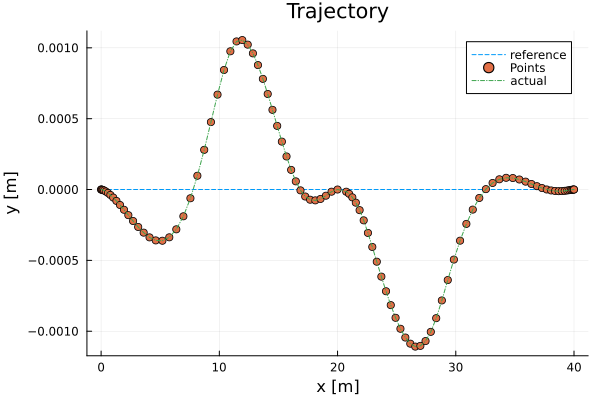

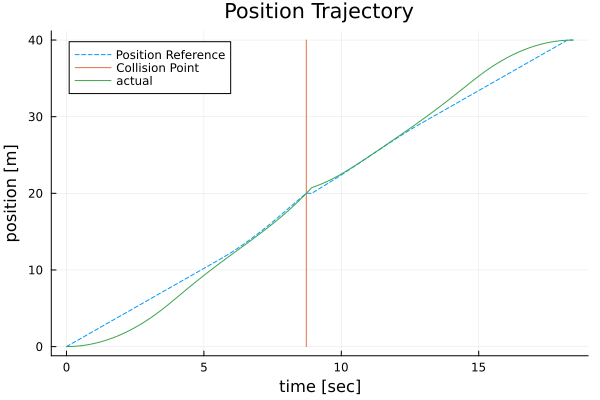

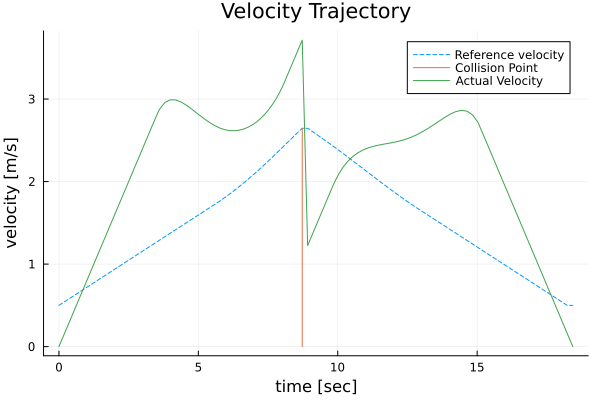

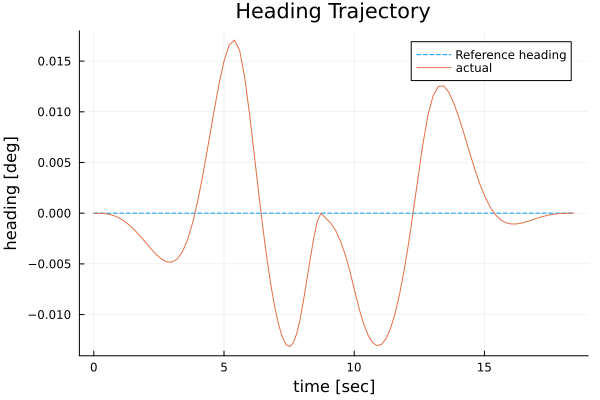

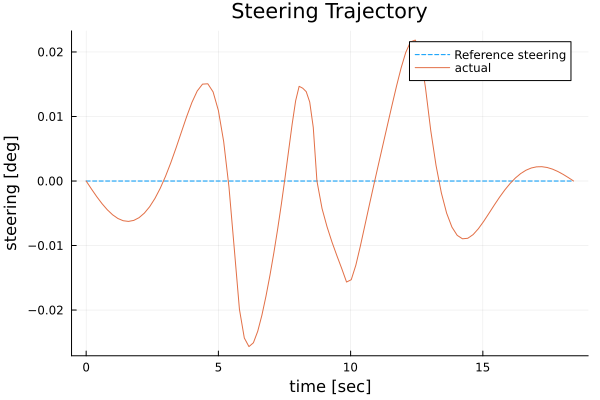

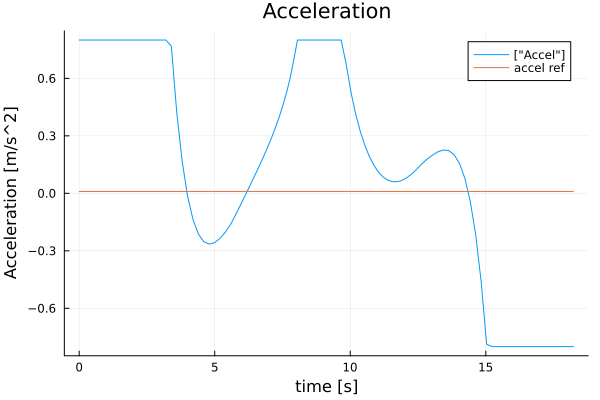

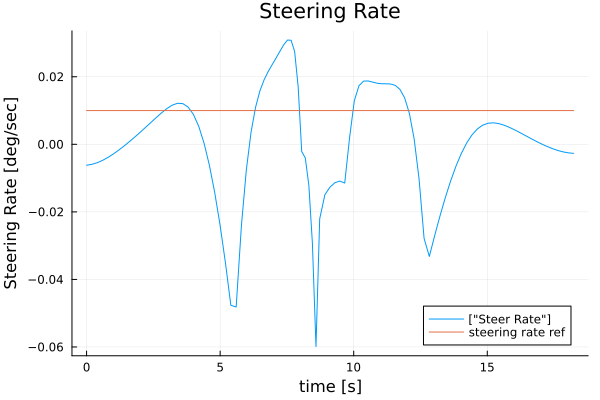

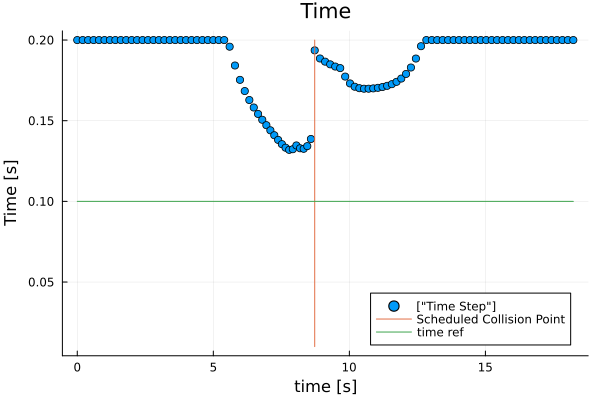

In [103]:
    plot(Xrefm[1,:], Xrefm[2,:], ls = :dash, label = "reference",
         xlabel = "x [m]", ylabel = "y [m]", title = "Trajectory")  
    scatter!(Xm[1,:], Xm[2,:], label = "Points")
    display(plot!(Xm[1,:], Xm[2,:], ls = :dashdot, label = "actual"))

    plot(time_vec[1:end], Xrefm[1,:], ls = :dash, label = "Position Reference",
             xlabel = "time [sec]", ylabel = "position [m]", title = "Position Trajectory")
plot!([time_vec[col_index],time_vec[col_index]], [0, maximum(Xm[1,:])], label = "Collision Point")
    display(plot!(time_vec[1:end], Xm[1,:], label = "actual"))
        
plot(time_vec[1:end], Xrefm[5,:], ls = :dash, label = "Reference velocity",
             xlabel = "time [sec]", ylabel = "velocity [m/s]", title = "Velocity Trajectory") 
plot!([time_vec[col_index],time_vec[col_index]], [min_v, xcol1[5]], label = "Collision Point")
display(plot!(time_vec[1:end], Xm[5,:], label = "Actual Velocity"))
        
plot(time_vec[1:end], 180/pi*Xrefm[3,:], ls = :dash, label = "Reference heading",
             xlabel = "time [sec]", ylabel = "heading [deg]", title = "Heading Trajectory")  
    display(plot!(time_vec[1:end], 180/pi*Xm[3,:], label = "actual"))    

plot(time_vec[1:end], 180/pi*Xrefm[4,:], ls = :dash, label = "Reference steering",
             xlabel = "time [sec]", ylabel = "steering [deg]", title = "Steering Trajectory")  
    display(plot!(time_vec[1:end], 180/pi*Xm[4,:], label = "actual"))   
    
plot(time_vec[1:end-1], Um[1,:],xlabel = "time [s]", ylabel = "Acceleration [m/s^2]",
                 label = ["Accel"], title = "Acceleration")
    display(plot!(time_vec[1:end-1], Urefm[1,:], label = "accel ref"))
        
plot(time_vec[1:end-1], 180/pi*Um[2,:],xlabel = "time [s]", ylabel = "Steering Rate [deg/sec]",
                 label = ["Steer Rate"], title = "Steering Rate")
    display(plot!(time_vec[1:end-1], Urefm[2,:], label = "steering rate ref")) 

scatter(time_vec[1:end-1], Um[3,:],xlabel = "time [s]", ylabel = "Time [s]",
                 label = ["Time Step"], title = "Time")
plot!([time_vec[col_index],time_vec[col_index]], [time_lower, time_upper], label = "Scheduled Collision Point")
display(plot!(time_vec[1:end-1], Urefm[3,:], label = "time ref"))

In [53]:
Xm_atten = Xm[:, 1:(end-1)];
X_atten = X[1:(end-1)];
XFULL = hcat(Xm);
UFULL = hcat(Um);
XTRAJ = vcat(X[1:end]);

In [54]:
    # animation
    vis = Visualizer()
    X_vis = [[xf[1],xf[2],0.1] for xf in XTRAJ]
    vis_traj!(vis, :traj, X_vis; R = 0.02)
    vis_model = TrajOptPlots.RobotZoo.BicycleModel()
    TrajOptPlots.set_mesh!(vis, vis_model)
    XMESH = [x[SA[1,2,3,4,5]] for x in XTRAJ]
    visualize!(vis, vis_model, (tf), XMESH)
    display(render(vis))

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8701


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("traj" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("p94" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x39, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s14" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x31, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s44" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x34, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s52" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x35, 0x32], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p92" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x39, 0x32], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p98" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x39, 0x38], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p6" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x61, 0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x36], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p23" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x32, 0x33], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p90" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x39, 0x30], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s94" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x39, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}())…)), "robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("chassis" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6f, 0x6d, 0x2f, 0x63, 0x68, 0x61, 0x73, 0x73, 0x69, 0x73], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTre